In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

In [2]:
df = pd.read_csv("ndt_tests_corrigido.csv")
quantis = [0.90, 0.95, 0.99]

excel_file = 'eda_data.xlsx'
writer = pd.ExcelWriter(excel_file)

df.describe()

,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent
count,7.087000e+03,7087.000000,7.087000e+03,7087.000000,7087.000000
mean,5.062996e+08,0.048447,3.781607e+08,0.037194,1.899137
std,3.352129e+08,0.067859,3.014096e+08,0.063537,3.449941
min,-1.000000e+00,-0.001000,-1.000000e+00,-1.000000,-1.000000
25%,1.642170e+08,0.008000,9.733497e+07,0.004918,0.001484
50%,5.960927e+08,0.011549,2.979242e+08,0.010858,0.189771
75%,8.489080e+08,0.115000,6.701694e+08,0.017723,2.050781
max,9.332671e+08,0.398051,9.214500e+08,0.360227,22.389090


Pré-processamento

In [3]:
df=df.dropna().drop_duplicates()

for i in df.columns:
    if df[i].dtypes != object:
        df = df[df[i] >= 0]

df.head()

,timestamp,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent,client,server
0,2025-08-09 15:28:02.000 +0000,8.223657e+07,0.231862,6.973217e+07,0.247727,0.000000,client12,server06
1,2025-08-09 15:30:11.000 +0000,9.027315e+08,0.012000,8.521780e+08,0.005423,0.008226,client01,server07
2,2025-08-10 04:27:43.000 +0000,5.910655e+08,0.014000,2.812188e+08,0.014544,5.954284,client13,server07
3,2025-08-09 22:45:07.000 +0000,6.721139e+08,0.011000,1.135400e+08,0.010482,0.261528,client12,server07
4,2025-08-10 04:49:21.000 +0000,8.122087e+08,0.009000,6.857905e+08,0.009368,1.381646,client03,server03


Manipulando colunas padronizadas para análise gráfica

In [4]:
df["download_mbps"] = df["download_throughput_bps"].div(1e6)
df["rtt_download_ms"] = df["rtt_download_sec"].mul(1e3)
df["upload_mbps"] = df["upload_throughput_bps"].div(1e6)
df["rtt_upload_ms"] = df["rtt_upload_sec"].mul(1e3)

df = df.rename(columns={"download_throughput_bps": "download_bps", 'upload_throughput_bps': 'upload_bps'})
df = df.sort_index()

df.head()

,timestamp,download_bps,rtt_download_sec,upload_bps,rtt_upload_sec,packet_loss_percent,client,server,download_mbps,rtt_download_ms,upload_mbps,rtt_upload_ms
0,2025-08-09 15:28:02.000 +0000,8.223657e+07,0.231862,6.973217e+07,0.247727,0.000000,client12,server06,82.236568,231.862,69.732172,247.727
1,2025-08-09 15:30:11.000 +0000,9.027315e+08,0.012000,8.521780e+08,0.005423,0.008226,client01,server07,902.731479,12.000,852.177960,5.423
2,2025-08-10 04:27:43.000 +0000,5.910655e+08,0.014000,2.812188e+08,0.014544,5.954284,client13,server07,591.065502,14.000,281.218794,14.544
3,2025-08-09 22:45:07.000 +0000,6.721139e+08,0.011000,1.135400e+08,0.010482,0.261528,client12,server07,672.113911,11.000,113.539960,10.482
4,2025-08-10 04:49:21.000 +0000,8.122087e+08,0.009000,6.857905e+08,0.009368,1.381646,client03,server03,812.208745,9.000,685.790475,9.368


In [5]:
numerical_cols = df.select_dtypes(include=[np.number]).columns

stats_dict = {}

# Fix: use correct column name 'download_bps' instead of 'downoload_bps'
for col in ['download_bps', 'rtt_download_sec', 'upload_bps', 'rtt_upload_sec', 'packet_loss_percent']:
    stats_dict[col] = {
        'Média': np.mean(df[col]),
        'Mediana': np.median(df[col]),
        'Variância': np.var(df[col]),
        'Desvio Padrão': np.std(df[col])
    }
    
    # Add quantiles
    quantiles = df[col].quantile(quantis)
    for q_value, q_result in zip(quantiles.index, quantiles.values):
        stats_dict[col][f'Quantil {q_value}'] = q_result

summary_df = pd.DataFrame(stats_dict)

summary_df.to_excel(writer, sheet_name="Geral", index=True)
print("Resumo Estatístico de Todas as Variáveis Numéricas:")
summary_df

Resumo Estatístico de Todas as Variáveis Numéricas:


,download_bps,rtt_download_sec,upload_bps,rtt_upload_sec,packet_loss_percent
Média,5.066665e+08,0.048477,3.781126e+08,0.037491,1.901662
Mediana,5.961251e+08,0.011566,2.979124e+08,0.010863,0.192572
Variância,1.122368e+17,0.004606,9.080681e+16,0.003735,11.905413
Desvio Padrão,3.350177e+08,0.067869,3.013417e+08,0.061115,3.450422
Quantil 0.9,9.081582e+08,0.122144,8.451371e+08,0.119846,6.295802
Quantil 0.95,9.125348e+08,0.220268,8.978140e+08,0.219830,9.250082
Quantil 0.99,9.256782e+08,0.233299,9.114748e+08,0.236531,18.130420


In [6]:
servers = df['server'].unique().tolist()

for server in servers: 
    stats_dict = {}
    for col in numerical_cols:
        server_data = df[df['server'] == server][col]
        
        stats_dict[col] = {
            'Média': np.mean(server_data),
            'Mediana': np.median(server_data),
            'Variância': np.var(server_data),
            'Desvio Padrão': np.std(server_data)
        }

        quantiles = server_data.quantile(quantis)
        for q_value, q_result in zip(quantiles.index, quantiles.values):
            stats_dict[col][f'Quantil {q_value}'] = q_result
    
    df1 = pd.DataFrame(stats_dict)
    #df1.to_excel(writer, sheet_name=f"{server}", index=True)

In [7]:
clients = df['client'].unique().tolist()

for client in clients: 
    stats_dict = {}
    for col in numerical_cols:
        client_data = df[df['client'] == client][col]
        
        stats_dict[col] = {
            'Média': np.mean(client_data),
            'Mediana': np.median(client_data),
            'Variância': np.var(client_data),
            'Desvio Padrão': np.std(client_data)
        }

        quantiles = client_data.quantile(quantis)
        for q_value, q_result in zip(quantiles.index, quantiles.values):
            stats_dict[col][f'Quantil {q_value}'] = q_result
    
    df1 = pd.DataFrame(stats_dict)
    #df1.to_excel(writer, sheet_name=f"{client}", index=True)

In [8]:
# Create separate dataframes for servers and clients with better structure
server_stats = []
for server in servers:
    server_data = df[df['server'] == server]
    row = {'Entity': server}
    
    for col in ['download_bps', 'rtt_download_sec', 'upload_bps', 'rtt_upload_sec', 'packet_loss_percent']:
        col_data = server_data[col]
        row[f'{col}_median'] = np.median(col_data)
        row[f'{col}_std'] = np.std(col_data)
        row[f'{col}_p95'] = col_data.quantile(0.95)
    
    server_stats.append(row)

client_stats = []
for client in clients:
    client_data = df[df['client'] == client]
    row = {'Entity': client}
    
    for col in ['download_bps', 'rtt_download_sec', 'upload_bps', 'rtt_upload_sec', 'packet_loss_percent']:
        col_data = client_data[col]
        row[f'{col}_median'] = np.median(col_data)
        row[f'{col}_std'] = np.std(col_data)
        row[f'{col}_p95'] = col_data.quantile(0.95)
    
    client_stats.append(row)

df_servers = pd.DataFrame(server_stats)
df_clients = pd.DataFrame(client_stats)

# Write to separate sheets
df_servers.to_excel(writer, sheet_name="Servers_Summary", index=False)
df_clients.to_excel(writer, sheet_name="Clients_Summary", index=False)

writer.close()

print("Servers Summary:")
display(df_servers)
print("\nClients Summary:")
display(df_clients)

Servers Summary:


,Entity,download_bps_median,download_bps_std,download_bps_p95,rtt_download_sec_median,rtt_download_sec_std,rtt_download_sec_p95,upload_bps_median,upload_bps_std,upload_bps_p95,rtt_upload_sec_median,rtt_upload_sec_std,rtt_upload_sec_p95,packet_loss_percent_median,packet_loss_percent_std,packet_loss_percent_p95
0,server06,1.695963e+08,1.906267e+08,6.035495e+08,0.118846,0.070978,0.232236,1.813935e+08,9.887963e+07,3.067827e+08,0.119007,0.072321,0.236928,0.000000,4.237045,12.065980
1,server07,7.093078e+08,3.283736e+08,9.147405e+08,0.009000,0.053671,0.122487,5.132071e+08,3.049185e+08,8.982019e+08,0.005447,0.005120,0.016118,0.089298,3.113885,8.607998
2,server03,7.683434e+08,2.784167e+08,9.097205e+08,0.011000,0.002468,0.016573,4.517895e+08,3.258906e+08,9.057805e+08,0.011203,0.004308,0.022025,0.835013,2.922625,8.443359
3,server02,7.618315e+08,2.773094e+08,9.104277e+08,0.011000,0.002541,0.016810,4.307226e+08,3.315412e+08,9.028542e+08,0.011247,0.004298,0.022211,0.805588,2.851140,8.245089
4,server05,1.688241e+08,1.828752e+08,5.983185e+08,0.118946,0.067570,0.230138,1.811563e+08,9.346010e+07,3.026025e+08,0.118818,0.068772,0.234965,0.000000,5.178560,17.384103
5,server01,7.617551e+08,2.685085e+08,9.109971e+08,0.011000,0.002280,0.015763,4.214657e+08,3.107795e+08,9.027359e+08,0.011140,0.004016,0.020489,1.016940,2.799891,7.611229
6,server04,1.685083e+08,1.771663e+08,5.980935e+08,0.118387,0.066567,0.230917,1.819216e+08,9.057938e+07,3.012830e+08,0.118841,0.067794,0.235438,0.000000,3.970620,12.172937



Clients Summary:


,Entity,download_bps_median,download_bps_std,download_bps_p95,rtt_download_sec_median,rtt_download_sec_std,rtt_download_sec_p95,upload_bps_median,upload_bps_std,upload_bps_p95,rtt_upload_sec_median,rtt_upload_sec_std,rtt_upload_sec_p95,packet_loss_percent_median,packet_loss_percent_std,packet_loss_percent_p95
0,client12,6.360041e+08,2.846531e+08,7.427643e+08,0.014583,0.103753,0.233019,9.603852e+07,3.039919e+07,1.396927e+08,0.017329,0.097222,0.236475,0.006149,0.430091,0.161440
1,client01,8.928297e+08,3.453200e+08,9.226672e+08,0.011000,0.053671,0.121764,8.788760e+08,2.877637e+08,9.138018e+08,0.006363,0.046535,0.120905,0.005476,1.667127,1.546393
2,client13,5.961439e+08,2.200760e+07,5.991948e+08,0.011926,0.005652,0.015000,2.989613e+08,1.657193e+07,3.017855e+08,0.014284,0.004991,0.015581,5.547862,1.211547,6.936176
3,client03,8.124696e+08,3.295229e+08,9.113763e+08,0.010000,0.056190,0.120963,5.922293e+08,2.098505e+08,7.491382e+08,0.004358,0.050523,0.119873,0.074979,1.435989,1.990165
4,client05,1.069629e+08,3.344077e+08,9.034872e+08,0.010000,0.054808,0.119729,1.085945e+08,3.510216e+08,9.049278e+08,0.004112,0.047237,0.119193,8.276383,5.290709,13.827504
5,client10,2.211362e+08,1.659125e+08,4.185677e+08,0.015269,0.103345,0.233935,4.076488e+07,9.261371e+06,4.596671e+07,0.016558,0.093674,0.237083,0.007470,2.875741,7.597659
6,client06,8.306604e+08,3.398674e+08,9.177186e+08,0.009941,0.056461,0.119756,7.388726e+08,2.554364e+08,8.745304e+08,0.003862,0.051610,0.119566,0.722961,1.016662,2.101069
7,client08,9.639645e+07,2.921090e+08,9.087625e+08,0.010000,0.067315,0.219000,9.732450e+07,2.495608e+08,7.631934e+08,0.005875,0.062087,0.219395,3.334843,6.074312,19.579608
8,client07,8.344313e+08,3.312094e+08,9.097496e+08,0.013000,0.057584,0.124073,5.508632e+08,1.920690e+08,7.403393e+08,0.008957,0.051501,0.123321,0.088475,1.557431,1.656797
9,client11,6.906440e+08,2.881997e+08,7.981449e+08,0.012963,0.006237,0.016045,3.829509e+08,1.649655e+08,4.214656e+08,0.015494,0.009127,0.018487,0.540977,1.943733,5.862084


Modelagem - client01

In [9]:
data_client= df[df['client'] == 'client05']
data_client

,timestamp,download_bps,rtt_download_sec,upload_bps,rtt_upload_sec,packet_loss_percent,client,server,download_mbps,rtt_download_ms,upload_mbps,rtt_upload_ms
5,2025-08-09 15:46:43.000 +0000,1.048641e+08,0.009000,1.080609e+08,0.009114,9.360405,client05,server03,104.864056,9.000,108.060920,9.114
10,2025-08-10 04:48:22.000 +0000,1.069575e+08,0.003000,1.085711e+08,0.004088,9.199443,client05,server07,106.957539,3.000,108.571082,4.088
20,2025-08-10 16:10:34.000 +0000,1.050130e+08,0.009965,1.085705e+08,0.003492,8.901770,client05,server07,105.013017,9.965,108.570471,3.492
47,2025-08-11 00:29:46.000 +0000,1.013662e+08,0.118000,9.551215e+07,0.119015,9.575605,client05,server06,101.366210,118.000,95.512148,119.015
53,2025-08-10 22:29:46.000 +0000,9.940268e+07,0.115000,1.085208e+08,0.004103,15.241362,client05,server07,99.402680,115.000,108.520810,4.103
...,...,...,...,...,...,...,...,...,...,...,...,...
6998,2025-08-30 15:43:21.000 +0000,1.817932e+08,0.115776,1.919397e+08,0.114763,0.000627,client05,server06,181.793220,115.776,191.939669,114.763
7017,2025-08-30 17:27:09.000 +0000,1.837652e+08,0.114904,7.660818e+08,0.003508,0.000000,client05,server07,183.765172,114.904,766.081788,3.508
7023,2025-08-30 18:25:49.000 +0000,8.644456e+08,0.003151,8.635176e+08,0.003115,0.000906,client05,server07,864.445631,3.151,863.517611,3.115
7038,2025-08-30 19:41:44.000 +0000,8.079248e+08,0.010000,8.971814e+08,0.009713,0.143859,client05,server03,807.924777,10.000,897.181442,9.713


Modelagem - server05

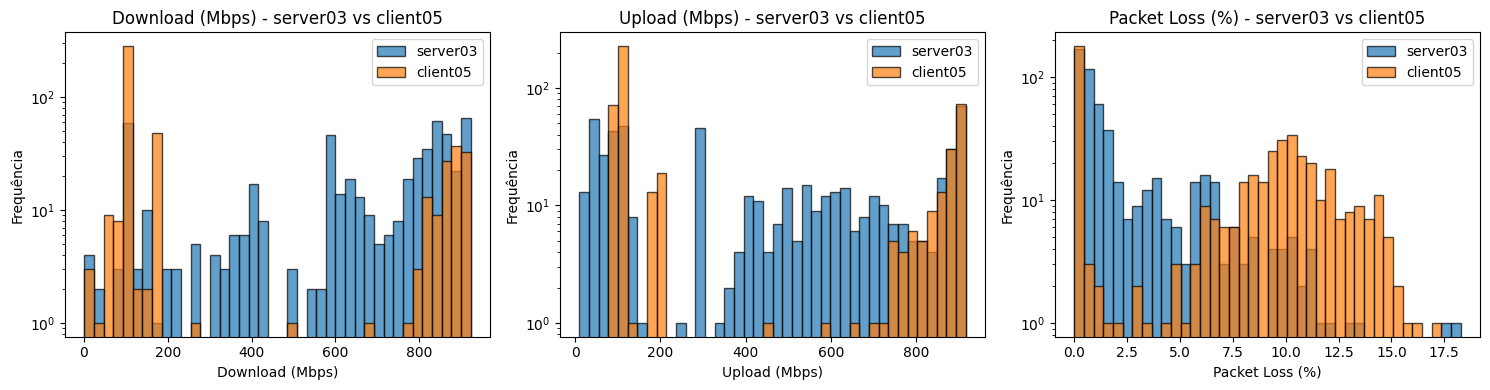

In [10]:
data_server = df[df['server'] == 'server03']
data_client = df[df['client'] == 'client05']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

var = 'download_mbps'

min_val = min(data_server[var].min(), data_client[var].min())
max_val = max(data_server[var].max(), data_client[var].max())

common_bins = np.linspace(min_val, max_val, 41)

axes[0].hist(data_server[var], bins=common_bins, edgecolor='black', alpha=0.7, label='server03')
axes[0].hist(data_client[var], bins=common_bins, edgecolor='black', alpha=0.7, label='client05')
axes[0].set_title('Download (Mbps) - server03 vs client05')
axes[0].set_xlabel('Download (Mbps)')
axes[0].set_ylabel('Frequência')
axes[0].set_yscale('log')
axes[0].legend()

var = 'upload_mbps'

min_val = min(data_server[var].min(), data_client[var].min())
max_val = max(data_server[var].max(), data_client[var].max())

common_bins = np.linspace(min_val, max_val, 41)

axes[1].hist(data_server[var], bins=common_bins, edgecolor='black', alpha=0.7, label='server03')
axes[1].hist(data_client[var], bins=common_bins, edgecolor='black', alpha=0.7, label='client05')
axes[1].set_title('Upload (Mbps) - server03 vs client05')
axes[1].set_xlabel('Upload (Mbps)')
axes[1].set_ylabel('Frequência')
axes[1].set_yscale('log')
axes[1].legend()

var = 'packet_loss_percent'

min_val = min(data_server[var].min(), data_client[var].min())
max_val = max(data_server[var].max(), data_client[var].max())

common_bins = np.linspace(min_val, max_val, 41)

axes[2].hist(data_server[var], bins=common_bins, edgecolor='black', alpha=0.7, label='server03')
axes[2].hist(data_client[var], bins=common_bins, edgecolor='black', alpha=0.7, label='client05')
axes[2].set_title('Packet Loss (%) - server03 vs client05')
axes[2].set_xlabel('Packet Loss (%)')
axes[2].set_ylabel('Frequência')
axes[2].set_yscale('log')
axes[2].legend()

plt.tight_layout()
plt.show()


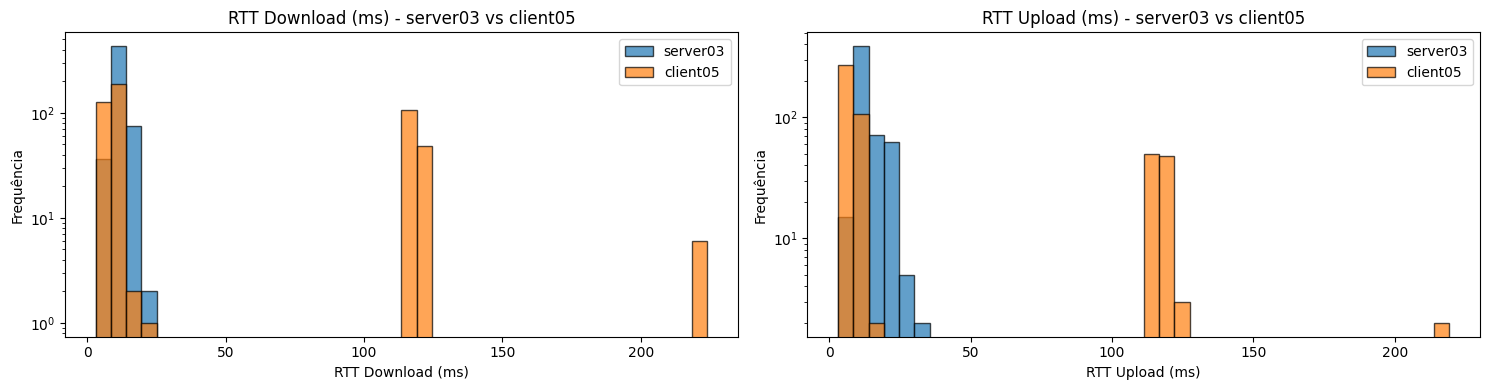

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
var = 'rtt_download_ms'

min_val = min(data_server[var].min(), data_client[var].min())
max_val = max(data_server[var].max(), data_client[var].max())

common_bins = np.linspace(min_val, max_val, 41)

axes[0].hist(data_server[var], bins=common_bins, edgecolor='black', alpha=0.7, label='server03')
axes[0].hist(data_client[var], bins=common_bins, edgecolor='black', alpha=0.7, label='client05')
axes[0].set_title('RTT Download (ms) - server03 vs client05')
axes[0].set_xlabel('RTT Download (ms)')
axes[0].set_ylabel('Frequência')
axes[0].set_yscale('log')
axes[0].legend()

var = 'rtt_upload_ms'

min_val = min(data_server[var].min(), data_client[var].min())
max_val = max(data_server[var].max(), data_client[var].max())

common_bins = np.linspace(min_val, max_val, 41)

axes[1].hist(data_server[var], bins=common_bins, edgecolor='black', alpha=0.7, label='server03')
axes[1].hist(data_client[var], bins=common_bins, edgecolor='black', alpha=0.7, label='client05')
axes[1].set_title('RTT Upload (ms) - server03 vs client05')
axes[1].set_xlabel('RTT Upload (ms)')
axes[1].set_ylabel('Frequência')
axes[1].set_yscale('log')
axes[1].legend()

plt.tight_layout()
plt.show()

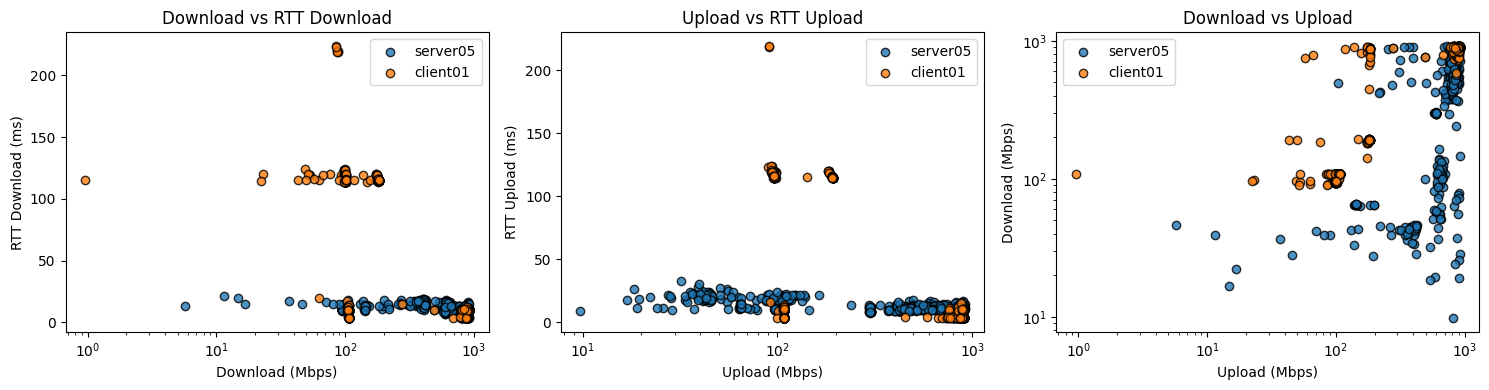

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(data_server['download_mbps'], data_server["rtt_download_ms"], alpha=0.8, edgecolor='black', label='server05')
axes[0].scatter(data_client['download_mbps'], data_client["rtt_download_ms"], alpha=0.8, edgecolor='black', label='client01')
axes[0].set_title('Download vs RTT Download')
axes[0].set_xlabel('Download (Mbps)')
axes[0].set_ylabel('RTT Download (ms)')
axes[0].set_xscale('log')
axes[0].legend()

axes[1].scatter(data_server['upload_mbps'], data_server['rtt_upload_ms'], alpha=0.8, edgecolor='black', label='server05')
axes[1].scatter(data_client['upload_mbps'], data_client['rtt_upload_ms'], alpha=0.8, edgecolor='black', label='client01')
axes[1].set_title('Upload vs RTT Upload')
axes[1].set_xlabel('Upload (Mbps)')
axes[1].set_ylabel('RTT Upload (ms)')
axes[1].set_xscale('log')
axes[1].legend()

axes[2].scatter(data_server['download_mbps'], data_server['upload_mbps'], alpha=0.8, edgecolor='black', label='server05')
axes[2].scatter(data_client['download_mbps'], data_client['upload_mbps'], alpha=0.8, edgecolor='black', label='client01')
axes[2].set_title('Download vs Upload')
axes[2].set_xlabel('Upload (Mbps)')
axes[2].set_ylabel('Download (Mbps)')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].legend()

plt.tight_layout()
plt.show()

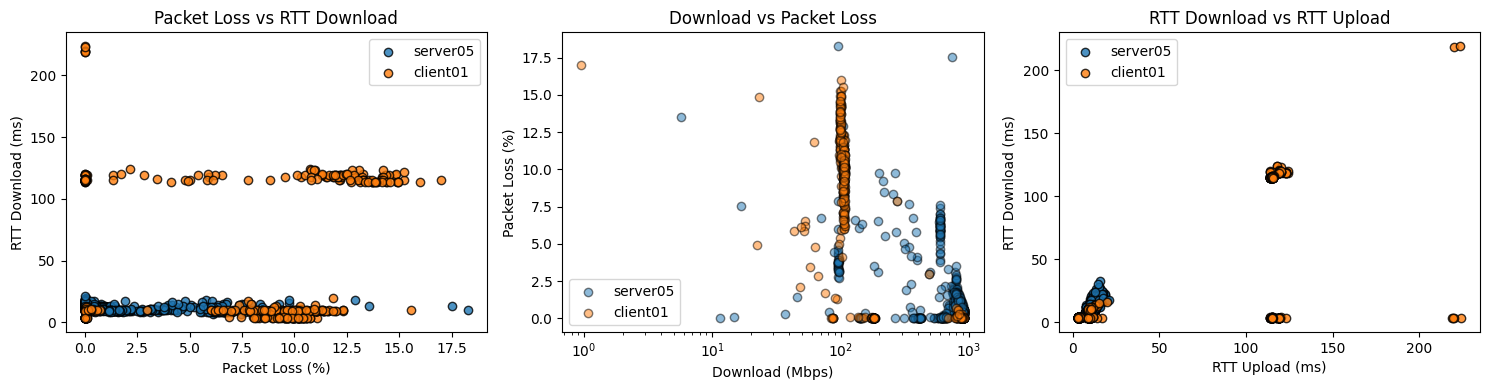

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(data_server['packet_loss_percent'], data_server["rtt_download_ms"], alpha=0.8, edgecolor='black', label='server05')
axes[0].scatter(data_client['packet_loss_percent'], data_client["rtt_download_ms"], alpha=0.8, edgecolor='black', label='client01')
axes[0].set_title('Packet Loss vs RTT Download')
axes[0].set_xlabel('Packet Loss (%)')
axes[0].set_ylabel('RTT Download (ms)')
axes[0].legend()

axes[1].scatter(data_server['download_mbps'], data_server['packet_loss_percent'], alpha=0.5, edgecolor='black', label='server05')
axes[1].scatter(data_client['download_mbps'], data_client['packet_loss_percent'], alpha=0.5, edgecolor='black', label='client01')
axes[1].set_title('Download vs Packet Loss')
axes[1].set_xlabel('Download (Mbps)')
axes[1].set_ylabel('Packet Loss (%)')
axes[1].set_xscale('log')
axes[1].legend()

axes[2].scatter(data_server['rtt_download_ms'], data_server['rtt_upload_ms'], alpha=0.8, edgecolor='black', label='server05')
axes[2].scatter(data_client['rtt_download_ms'], data_client['rtt_upload_ms'], alpha=0.8, edgecolor='black', label='client01')
axes[2].set_title('RTT Download vs RTT Upload')
axes[2].set_xlabel('RTT Upload (ms)')
axes[2].set_ylabel('RTT Download (ms)')
axes[2].legend()

plt.tight_layout()
plt.show()

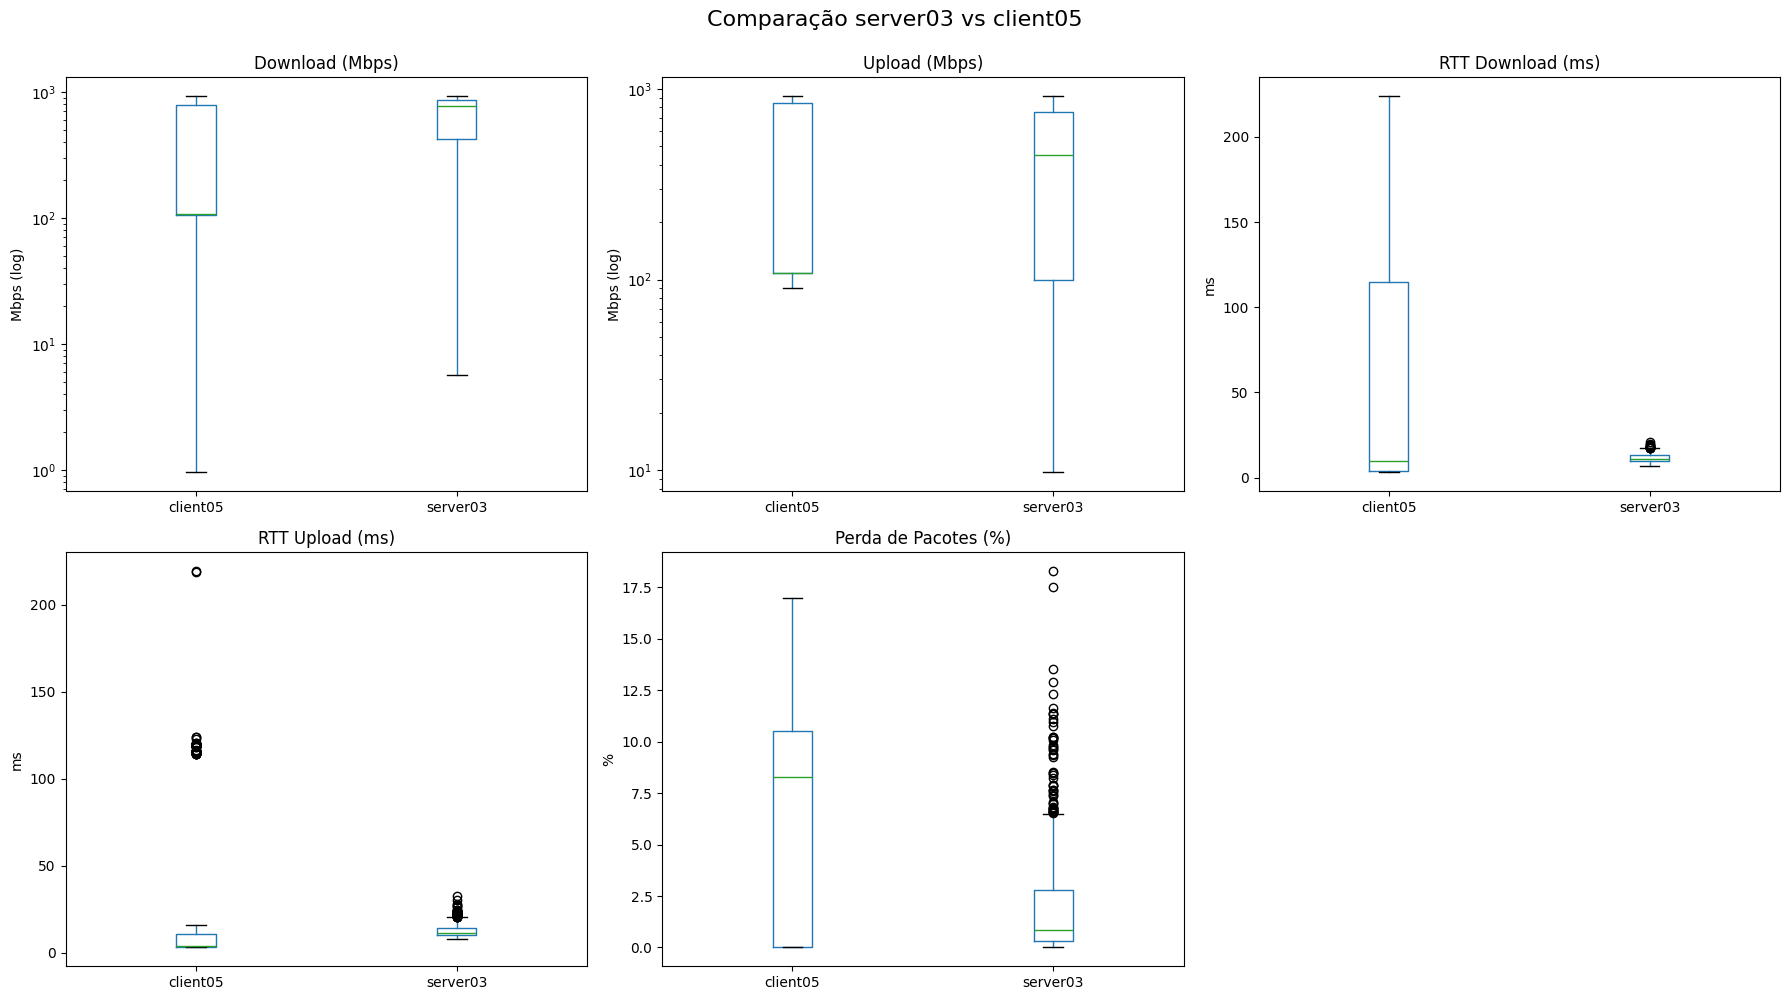

In [14]:
# Create combined dataframe for boxplot comparison
df_server_plot = data_server[['download_mbps', 'upload_mbps', 'rtt_download_ms', 'rtt_upload_ms', 'packet_loss_percent']].copy()
df_server_plot['group'] = 'server03'

df_client_plot = data_client[['download_mbps', 'upload_mbps', 'rtt_download_ms', 'rtt_upload_ms', 'packet_loss_percent']].copy()
df_client_plot['group'] = 'client05'

df_plot = pd.concat([df_server_plot, df_client_plot], ignore_index=True)
df_plot = df_plot.rename(columns={
    'download_mbps': 'download_Mbps',
    'upload_mbps': 'upload_Mbps',
    'rtt_download_ms': 'rtt_d_ms',
    'rtt_upload_ms': 'rtt_u_ms',
    'packet_loss_percent': 'loss_pct'
})

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

plots = [
    ("download_Mbps", "Download (Mbps)", True),
    ("upload_Mbps",   "Upload (Mbps)",   True),
    ("rtt_d_ms",      "RTT Download (ms)",           False),
    ("rtt_u_ms",      "RTT Upload (ms)",             False),
    ("loss_pct",      "Perda de Pacotes (%)",        False),
]

for idx, (col, title, use_log) in enumerate(plots):
    df_plot.boxplot(column=col, by="group", ax=axes[idx], grid=False, showfliers=True)
    axes[idx].set_title(title)
    axes[idx].set_xlabel("")
    
    if use_log:
        axes[idx].set_yscale("log")
        axes[idx].set_ylabel("Mbps (log)")
    elif "RTT" in title:
        axes[idx].set_ylabel("ms")
    else:
        axes[idx].set_ylabel("%")
    
    axes[idx].get_figure().suptitle("")

# Hide the 6th subplot since we only have 5 plots
axes[5].set_visible(False)

plt.suptitle("Comparação server03 vs client05", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


MLE

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize, special

# Conversões de unidade
to_Mbps = lambda x_bps: np.asarray(x_bps, float) / 1e6
to_ms   = lambda x_sec: np.asarray(x_sec, float) * 1e3

def to_prop_from_percent(pct, eps=1e-6):
    """% -> proporção em (0,1), com clip para evitar 0/1 exatos."""
    z = np.asarray(pct, float) / 100.0
    return np.clip(z, eps, 1 - eps)

def clean_pos(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x) & (x > 0)]
    return x

def clean_any(x):
    x = np.asarray(x, float)
    return x[np.isfinite(x)]


In [16]:
# ===== RTT ~ Normal =====
def mle_normal(x):
    x = clean_any(x)
    mu = np.mean(x)
    sigma = np.sqrt(np.mean((x - mu)**2))  # MLE (denominador n)
    return {"mu": mu, "sigma": sigma}

def plot_normal(x, pars, title, xlabel):
    """Plot histogram + PDF and QQ-plot side by side"""
    x = clean_any(x)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Left: Histogram + Model
    ax1.hist(x, bins="auto", density=True, alpha=0.6, edgecolor="none")
    xx = np.linspace(x.min(), x.max(), 400)
    yy = stats.norm.pdf(xx, loc=pars["mu"], scale=pars["sigma"])
    ax1.plot(xx, yy, lw=2, label="Normal MLE")
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel("densidade")
    ax1.legend()
    
    # Right: QQ-plot
    n = len(x)
    p = (np.arange(1, n+1) - 0.5) / n
    q_theo = stats.norm.ppf(p, loc=pars["mu"], scale=pars["sigma"])
    x_sorted = np.sort(x)
    ax2.scatter(q_theo, x_sorted, s=12, alpha=0.6)
    m, M = min(q_theo.min(), x_sorted.min()), max(q_theo.max(), x_sorted.max())
    ax2.plot([m, M], [m, M], color='orange', lw=2)
    ax2.set_title(f"QQ plot ({title})")
    ax2.set_xlabel("quantis teóricos")
    ax2.set_ylabel("quantis empíricos")
    
    plt.tight_layout()
    plt.show()

# ===== Throughput ~ Gamma (shape, rate) =====
def mle_gamma(x):
    x = clean_pos(x)
    # scipy: shape=k, loc, scale=theta
    k, loc, theta = stats.gamma.fit(x, floc=0.0)
    beta = 1.0 / theta
    return {"k": k, "beta": beta, "theta": theta}

def plot_gamma(x, pars, title, xlabel):
    """Plot histogram + PDF and QQ-plot side by side"""
    x = clean_pos(x)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Left: Histogram + Model
    ax1.hist(x, bins="auto", density=True, alpha=0.6, edgecolor="none")
    xx = np.linspace(x.min(), x.max(), 400)
    yy = stats.gamma.pdf(xx, pars["k"], loc=0.0, scale=pars["theta"])
    ax1.plot(xx, yy, lw=2, label="Gamma MLE")
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel("densidade")
    ax1.legend()
    
    # Right: QQ-plot
    n = len(x)
    p = (np.arange(1, n+1) - 0.5) / n
    q_theo = stats.gamma.ppf(p, a=pars["k"], loc=0.0, scale=pars["theta"])
    x_sorted = np.sort(x)
    ax2.scatter(q_theo, x_sorted, s=12, alpha=0.6)
    m, M = min(q_theo.min(), x_sorted.min()), max(q_theo.max(), x_sorted.max())
    ax2.plot([m, M], [m, M], color='orange', lw=2)
    ax2.set_title(f"QQ plot ({title})")
    ax2.set_xlabel("quantis teóricos")
    ax2.set_ylabel("quantis empíricos")
    
    plt.tight_layout()
    plt.show()

# ===== Packet loss ~ Binomial(n, p) =====
def mle_binomial_from_percent(pct, n_trials=1000):
    """
    MLE para Binomial(n, p) com n fixo.
    Converte percentagens para contagens e estima p.
    """
    pct = np.asarray(pct)
    z = pct / 100.0  # Convert from percentage to proportion
    z = np.clip(z, 0, 1)  # Ensure values are in [0,1]
    
    k = np.clip(np.round(z * n_trials).astype(int), 0, n_trials)
    p_hat = np.mean(k) / n_trials
    
    return {"p": float(p_hat), "n": int(n_trials)}, k


def plot_binomial(k, n, pars, title, xlabel="Packet Loss (proporção)"):
    """
    Plot histogram + PMF and QQ-plot side by side.
    Escala correta: PMF em contagens k precisa ser multiplicado por n quando plotado em proporções.
    """
    from scipy.stats import binom
    
    # Convert counts to proportions
    prop = k / n
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Left: Histogram + Model
    ax1.hist(prop, bins="auto", density=True, alpha=0.6, edgecolor="none")
    
    # Plot Binomial PMF scaled correctly for proportion space
    ks = np.arange(0, n+1)
    pmf = binom.pmf(ks, n, pars["p"])
    xs = ks / n  # Convert to proportions
    pmf_density = pmf * n  # Scale to density (pmf / dx, where dx = 1/n)
    ax1.plot(xs, pmf_density, lw=2, label="Binomial MLE")
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel("densidade")
    ax1.legend()
    
    # Right: QQ-plot
    k_sorted = np.sort(k)
    m = len(k_sorted)
    p_empirical = (np.arange(1, m+1) - 0.5) / m
    q_theo = binom.ppf(p_empirical, n, pars["p"])
    
    ax2.scatter(q_theo, k_sorted, s=12, alpha=0.5)
    m_val, M_val = min(q_theo.min(), k_sorted.min()), max(q_theo.max(), k_sorted.max())
    ax2.plot([m_val, M_val], [m_val, M_val], color='orange', lw=2)
    ax2.set_title(f"QQ plot ({title})")
    ax2.set_xlabel("quantis teóricos")
    ax2.set_ylabel("quantis empíricos")
    
    plt.tight_layout()
    plt.show()

In [17]:
def run_mle_for(df, label="entity", n_trials_loss=1000):
    results = {}

    # === Throughput: Download ~ Gamma ===
    x = to_Mbps(df["download_bps"])
    par = mle_gamma(x); results["download_gamma"] = par
    print(f"[{label}] Download ~ Gamma: k={par['k']:.4f}, beta={par['beta']:.6f}  (theta=1/beta={par['theta']:.6f})")
    plot_gamma(x, par, f"{label} — Download (Gamma MLE)", "Download (Mbps)")

    # === Throughput: Upload ~ Gamma ===
    x = to_Mbps(df["upload_bps"])
    par = mle_gamma(x); results["upload_gamma"] = par
    print(f"[{label}] Upload   ~ Gamma: k={par['k']:.4f}, beta={par['beta']:.6f}  (theta=1/beta={par['theta']:.6f})")
    plot_gamma(x, par, f"{label} — Upload (Gamma MLE)", "Upload (Mbps)")

    # === RTT: Download ~ Normal ===
    x = to_ms(df["rtt_download_sec"])
    par = mle_normal(x); results["rtt_download_normal"] = par
    print(f"[{label}] RTT-Down ~ Normal: mu={par['mu']:.3f} ms, sigma={par['sigma']:.3f} ms")
    plot_normal(x, par, f"{label} — RTT Download (Normal MLE)", "RTT Download (ms)")

    # === RTT: Upload ~ Normal ===
    x = to_ms(df["rtt_upload_sec"])
    par = mle_normal(x); results["rtt_upload_normal"] = par
    print(f"[{label}] RTT-Up   ~ Normal: mu={par['mu']:.3f} ms, sigma={par['sigma']:.3f} ms")
    plot_normal(x, par, f"{label} — RTT Upload (Normal MLE)", "RTT Upload (ms)")

    # === Packet Loss: Binomial ===
    pars, k = mle_binomial_from_percent(df["packet_loss_percent"], n_trials=n_trials_loss)
    results["packetloss_binomial"] = pars
    print(f"[{label}] Loss ~ Binomial: n={pars['n']}, p={pars['p']:.6f}")
    plot_binomial(k, pars["n"], pars, f"{label} — Packet Loss (Binomial MLE)", "Packet Loss (proporção)")

    return results


=== CLIENTE ===
[client05] Download ~ Gamma: k=1.1132, beta=0.003596  (theta=1/beta=278.063036)


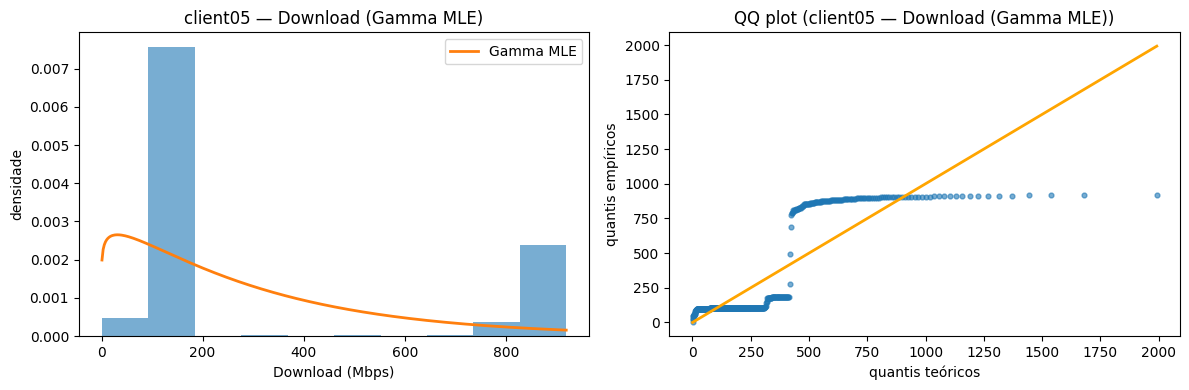

[client05] Upload   ~ Gamma: k=1.1342, beta=0.003261  (theta=1/beta=306.608954)


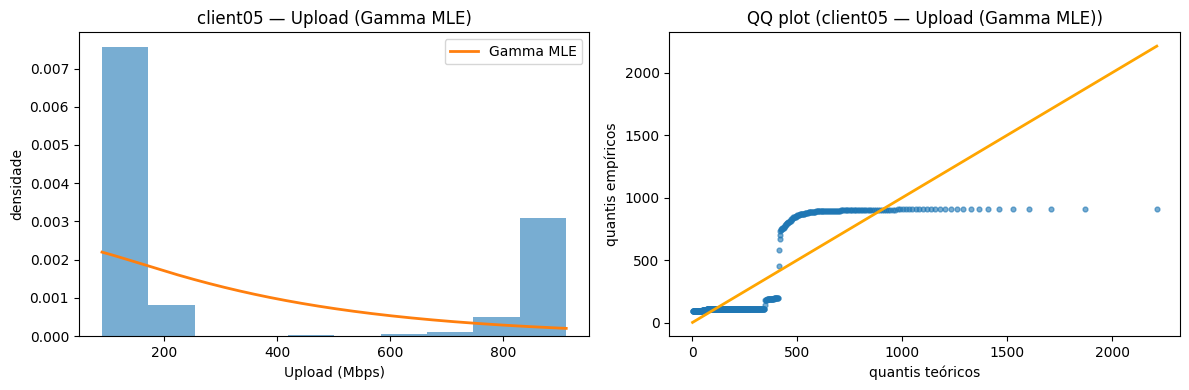

[client05] RTT-Down ~ Normal: mu=45.166 ms, sigma=54.808 ms


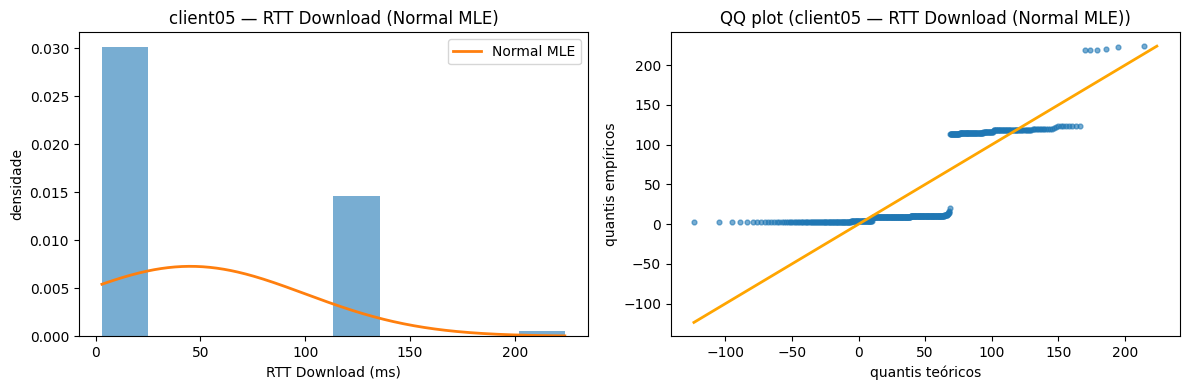

[client05] RTT-Up   ~ Normal: mu=29.707 ms, sigma=47.237 ms


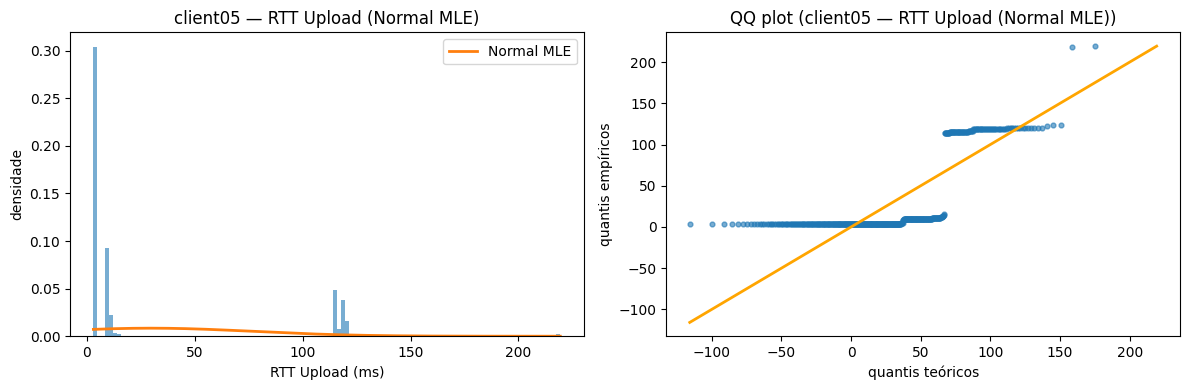

[client05] Loss ~ Binomial: n=1000, p=0.063077


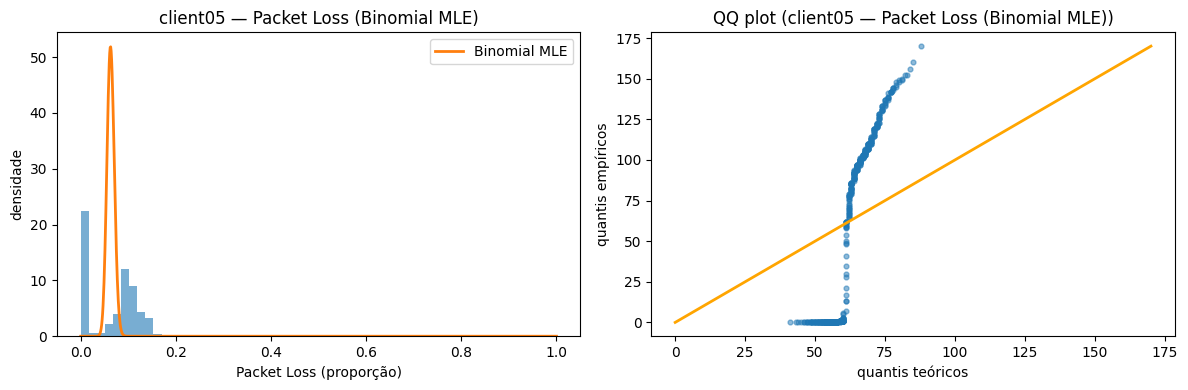


=== SERVIDOR ===
[server03] Download ~ Gamma: k=2.5907, beta=0.004058  (theta=1/beta=246.435992)


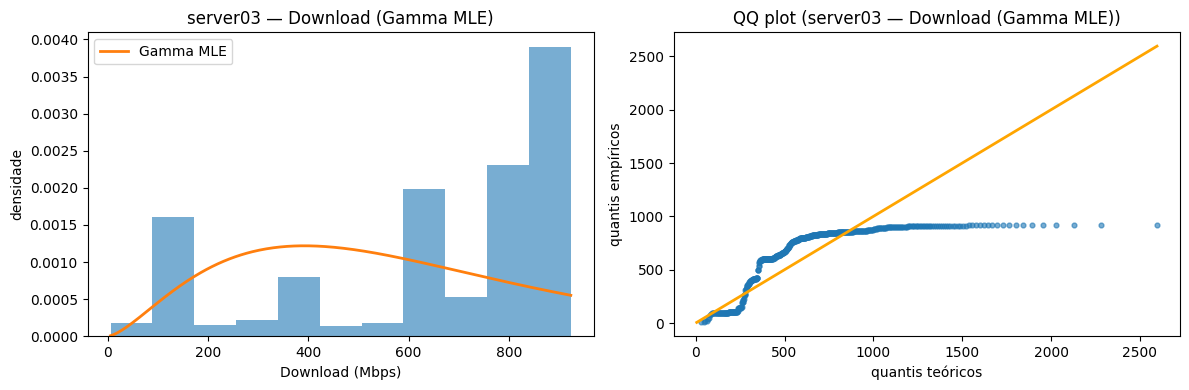

[server03] Upload   ~ Gamma: k=1.2111, beta=0.002702  (theta=1/beta=370.104074)


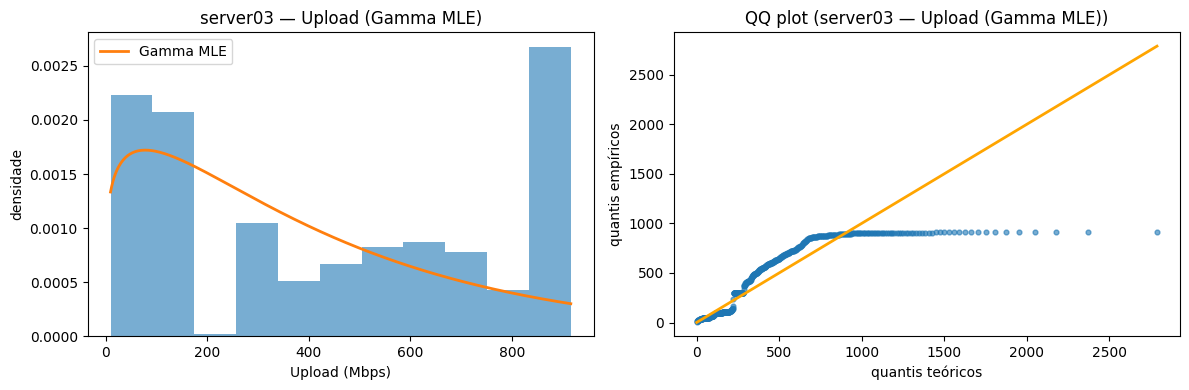

[server03] RTT-Down ~ Normal: mu=11.467 ms, sigma=2.468 ms


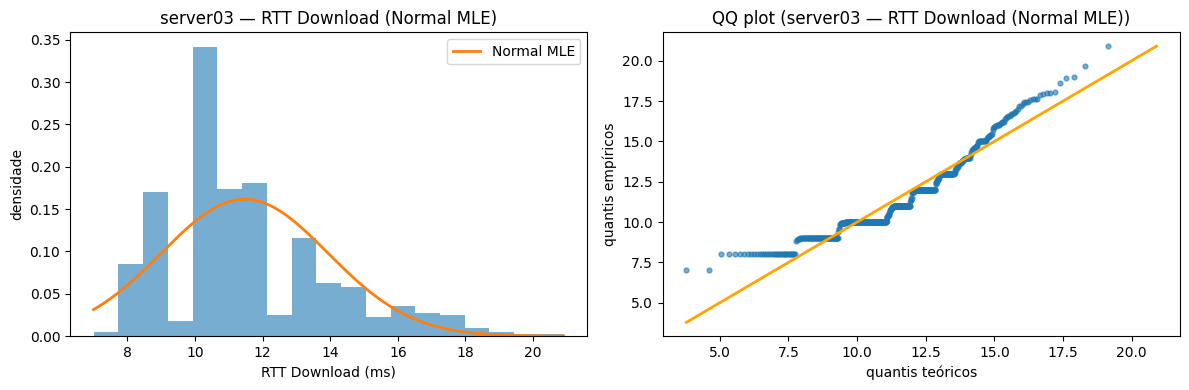

[server03] RTT-Up   ~ Normal: mu=12.940 ms, sigma=4.308 ms


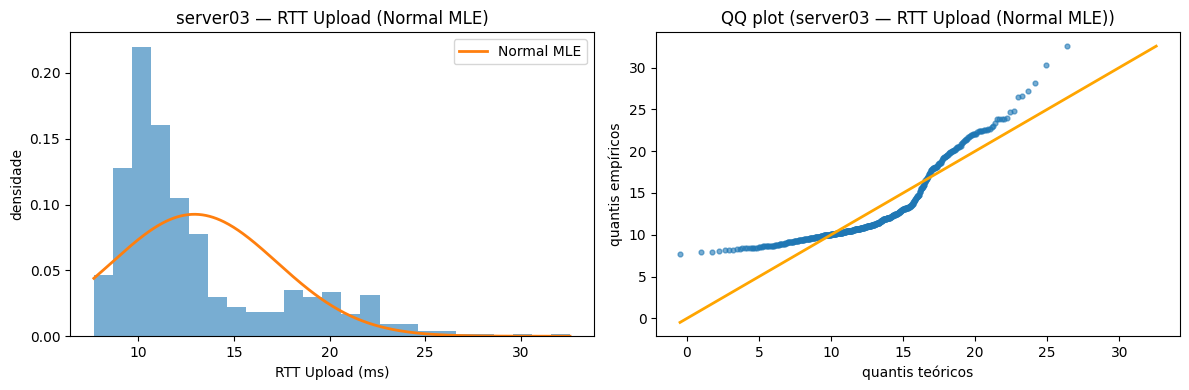

[server03] Loss ~ Binomial: n=1000, p=0.021285


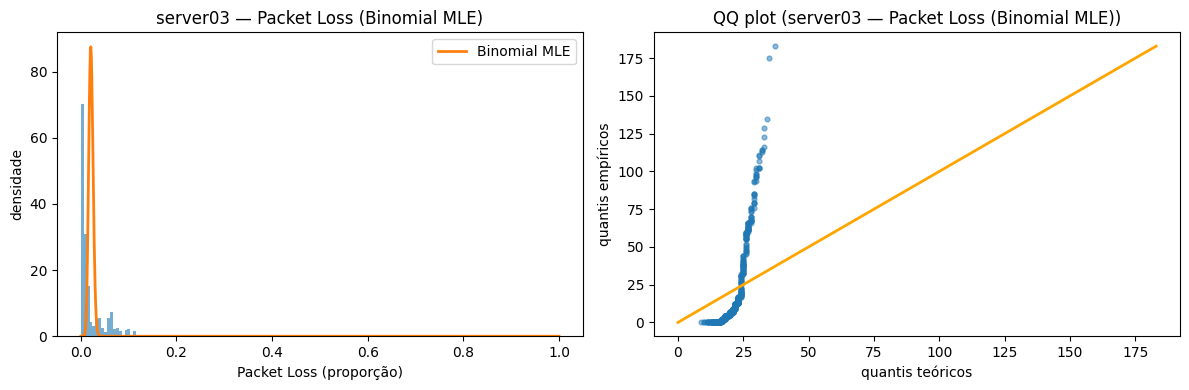

In [18]:
# Escolha os DFs que representam client01 e server05 (ou outros):
# data_client, data_server já existem no seu ambiente.

print("=== CLIENTE ===")
res_client  = run_mle_for(data_client, label="client05", n_trials_loss=1000)

print("\n=== SERVIDOR ===")
res_server  = run_mle_for(data_server, label="server03", n_trials_loss=1000)

# Os dicts res_client/res_server guardam os parâmetros \hat{\theta}_{MLE} para cada variável.
# Para packet loss: agora usando Binomial(n=1000, p) em vez de Beta-Binomial.


In [19]:
from sklearn.model_selection import train_test_split
from scipy.special import gammaln, gamma
from scipy.stats import norm, beta, t

client_train, client_test = train_test_split(
    data_client,
    test_size=0.2,
    random_state=42
)

server_train, server_test = train_test_split(
    data_server,
    test_size=0.2,
    random_state=42
)

print(f"Dados do Cliente: {len(data_client)} amostras -> Treino: {len(client_train)}, Teste: {len(client_test)}")
print(f"Dados do Servidor: {len(data_server)} amostras -> Treino: {len(server_train)}, Teste: {len(server_test)}")

k_mle_d_c = res_client['download_gamma']['k']
k_mle_u_c = res_client['upload_gamma']['k']
sigma_mle_rd_c = res_client['rtt_download_normal']['sigma']
sigma_mle_ru_c = res_client['rtt_upload_normal']['sigma']
n_mle_l_c = res_client['packetloss_binomial']['n'] # n=1000


k_mle_d_s = res_server['download_gamma']['k']
k_mle_u_s = res_server['upload_gamma']['k']
sigma_mle_rd_s = res_server['rtt_download_normal']['sigma']
sigma_mle_ru_s = res_server['rtt_upload_normal']['sigma']
n_mle_l_s = res_server['packetloss_binomial']['n'] # n=1000

Dados do Cliente: 482 amostras -> Treino: 385, Teste: 97
Dados do Servidor: 544 amostras -> Treino: 435, Teste: 109


Modelo Download - Gamma-Gamma 

In [20]:
# --- CLIENTE 05 (Download) ---

alpha_0_d = 1
beta_0_d = 1e-8

y_train_d_c = to_Mbps(client_train['download_bps'])
n_d_c = len(y_train_d_c)
sum_y_d_c = y_train_d_c.sum()

alpha_n_d_c = alpha_0_d + n_d_c * k_mle_d_c
beta_n_d_c = beta_0_d + sum_y_d_c

print("--- CLIENTE 05 (Download) ---")
print(f"Parâmetros da Posterior p(λ|y) ~ Gamma(α_n, β_n):")
print(f"α_n = {alpha_n_d_c:.4f}")
print(f"β_n = {beta_n_d_c:.4f}")
print(f"Média E[λ] = α_n / β_n = {(alpha_n_d_c / beta_n_d_c):.4f} Mbps")


# --- SERVER 03 (Download) ---

alpha_0_d = 1
beta_0_d = 1e-8

y_train_d_s = to_Mbps(server_train['download_bps'])
n_d_s = len(y_train_d_s)
sum_y_d_s = y_train_d_s.sum()

alpha_n_d_s = alpha_0_d + n_d_s * k_mle_d_s
beta_n_d_s = beta_0_d + sum_y_d_s

print("\n--- SERVER 03 (Download) ---")
print(f"Parâmetros da Posterior p(λ|y) ~ Gamma(α_n, β_n):")
print(f"α_n = {alpha_n_d_s:.4f}")
print(f"β_n = {beta_n_d_s:.4f}")
print(f"Média E[λ] = α_n / β_n = {(alpha_n_d_s / beta_n_d_s):.4f} Mbps")

--- CLIENTE 05 (Download) ---
Parâmetros da Posterior p(λ|y) ~ Gamma(α_n, β_n):
α_n = 429.5698
β_n = 116567.9946
Média E[λ] = α_n / β_n = 0.0037 Mbps

--- SERVER 03 (Download) ---
Parâmetros da Posterior p(λ|y) ~ Gamma(α_n, β_n):
α_n = 1127.9368
β_n = 275071.0041
Média E[λ] = α_n / β_n = 0.0041 Mbps


In [21]:
# --- CLIENTE 05 (Download) ---
E_pred_d_c = (k_mle_d_c * beta_n_d_c) / (alpha_n_d_c - 1)
Var_pred_d_c = (k_mle_d_c * (k_mle_d_c + alpha_n_d_c - 1) * (beta_n_d_c**2)) / \
               ((alpha_n_d_c - 1)**2 * (alpha_n_d_c - 2))


mean_test_d_c = to_Mbps(client_test['download_bps']).mean()
var_test_d_c = to_Mbps(client_test['download_bps']).var()

# --- SERVER 03 (Download) ---
E_pred_d_s = (k_mle_d_s * beta_n_d_s) / (alpha_n_d_s - 1)
Var_pred_d_s = (k_mle_d_s * (k_mle_d_s + alpha_n_d_s - 1) * (beta_n_d_s**2)) / \
               ((alpha_n_d_s - 1)**2 * (alpha_n_d_s - 2))

mean_test_d_s = to_Mbps(server_test['download_bps']).mean()
var_test_d_s = to_Mbps(server_test['download_bps']).var()

comp_df_d = pd.DataFrame({
    'Entidade': ['Cliente 05', 'Servidor 03'],
    'E[Preditiva] (Mbps)': [E_pred_d_c, E_pred_d_s],
    'Média (Teste) (Mbps)': [mean_test_d_c, mean_test_d_s],
    'Var[Preditiva] (Mbps^2)': [Var_pred_d_c, Var_pred_d_s],
    'Variância (Teste) (Mbps^2)': [var_test_d_c, var_test_d_s]
})

print("--- COMPARAÇÃO: PREDITIVA POSTERIOR (DOWNLOAD) vs DADOS DE TESTE ---")
comp_df_d.set_index('Entidade')

--- COMPARAÇÃO: PREDITIVA POSTERIOR (DOWNLOAD) vs DADOS DE TESTE ---


,E[Preditiva] (Mbps),Média (Teste) (Mbps),Var[Preditiva] (Mbps^2),Variância (Teste) (Mbps^2)
Entidade,,,,
Cliente 05,302.774012,336.349820,82759.424214,120432.995592
Servidor 03,632.347136,662.713988,154840.157989,65977.410955


In [22]:
# --- CLIENTE 05 (Upload) ---

alpha_0_u = 1
beta_0_u = 1e-8

y_train_u_c = to_Mbps(client_train['upload_bps'])
n_u_c = len(y_train_u_c)
sum_y_u_c = y_train_u_c.sum()

alpha_n_u_c = alpha_0_u + n_u_c * k_mle_u_c
beta_n_u_c = beta_0_u + sum_y_u_c

print("--- CLIENTE 05 (Upload) ---")
print(f"Parâmetros da Posterior p(λ|y) ~ Gamma(α_n, β_n):")
print(f"α_n = {alpha_n_u_c:.4f}")
print(f"β_n = {beta_n_u_c:.4f}")
print(f"Média E[λ] = α_n / β_n = {(alpha_n_u_c / beta_n_u_c):.4f} Mbps")


# --- SERVER 03 (Upload) ---

alpha_0_u = 1
beta_0_u = 1e-8

y_train_u_s = to_Mbps(server_train['upload_bps'])
n_u_s = len(y_train_u_s)
sum_y_u_s = y_train_u_s.sum()

alpha_n_u_s = alpha_0_u + n_u_s * k_mle_u_s
beta_n_u_s = beta_0_u + sum_y_u_s

print("\n--- SERVER 03 (Upload) ---")
print(f"Parâmetros da Posterior p(λ|y) ~ Gamma(α_n, β_n):")
print(f"α_n = {alpha_n_u_s:.4f}")
print(f"β_n = {beta_n_u_s:.4f}")
print(f"Média E[λ] = α_n / β_n = {(alpha_n_u_s / beta_n_u_s):.4f} Mbps")

--- CLIENTE 05 (Upload) ---
Parâmetros da Posterior p(λ|y) ~ Gamma(α_n, β_n):
α_n = 437.6624
β_n = 132009.2011
Média E[λ] = α_n / β_n = 0.0033 Mbps

--- SERVER 03 (Upload) ---
Parâmetros da Posterior p(λ|y) ~ Gamma(α_n, β_n):
α_n = 527.8393
β_n = 193144.3728
Média E[λ] = α_n / β_n = 0.0027 Mbps


In [23]:
# --- CLIENTE 05 (Upload) ---
E_pred_u_c = (k_mle_u_c * beta_n_u_c) / (alpha_n_u_c - 1)
Var_pred_u_c = (k_mle_u_c * (k_mle_u_c + alpha_n_u_c - 1) * (beta_n_u_c**2)) / \
               ((alpha_n_u_c - 1)**2 * (alpha_n_u_c - 2))


mean_test_u_c = to_Mbps(client_test['upload_bps']).mean()
var_test_u_c = to_Mbps(client_test['upload_bps']).var()

# --- SERVER 03 (Upload) ---
E_pred_u_s = (k_mle_u_s * beta_n_u_s) / (alpha_n_u_s - 1)
Var_pred_u_s = (k_mle_u_s * (k_mle_u_s + alpha_n_u_s - 1) * (beta_n_u_s**2)) / \
               ((alpha_n_u_s - 1)**2 * (alpha_n_u_s - 2))

mean_test_u_s = to_Mbps(server_test['upload_bps']).mean()
var_test_u_s = to_Mbps(server_test['upload_bps']).var()

comp_df_u = pd.DataFrame({
    'Entidade': ['Cliente 05', 'Servidor 03'],
    'E[Preditiva] (Mbps)': [E_pred_u_c, E_pred_u_s],
    'Média (Teste) (Mbps)': [mean_test_u_c, mean_test_u_s],
    'Var[Preditiva] (Mbps^2)': [Var_pred_u_c, Var_pred_u_s],
    'Variância (Teste) (Mbps^2)': [var_test_u_c, var_test_u_s]
})

print("--- COMPARAÇÃO: PREDITIVA POSTERIOR (UPLOAD) vs DADOS DE TESTE ---")
comp_df_u.set_index('Entidade')

--- COMPARAÇÃO: PREDITIVA POSTERIOR (UPLOAD) vs DADOS DE TESTE ---


,E[Preditiva] (Mbps),Média (Teste) (Mbps),Var[Preditiva] (Mbps^2),Variância (Teste) (Mbps^2)
Entidade,,,,
Cliente 05,342.881042,367.086217,104165.565691,125768.517301
Servidor 03,444.010052,465.132131,163462.844680,98737.337220


Modelo RTT - Normal-Normal

In [24]:
# CÉLULA 7: Cálculo Posterior (RTT-Download)

# --- CLIENTE 05 (RTT-Download) ---

# 1. Definir Prior
mu_0_r = 48.5  # Prior mean in ms (0.0485 s * 1000)
sigma2_0_r = 1000.0**2 # Prior fracamente informativa (em ms^2)

# 2. Obter dados de treino (converter para ms)
y_train_r_c = to_ms(client_train['rtt_download_sec'])
n_r_c = len(y_train_r_c)
mean_y_r_c = y_train_r_c.mean()
sigma2_mle_r_c = sigma_mle_rd_c**2 # Variância 'conhecida' do MLE (em ms^2)

# 3. Calcular parâmetros da Posterior
sigma2_n_r_c = 1.0 / ( (1.0 / sigma2_0_r) + (n_r_c / sigma2_mle_r_c) )
mu_n_r_c = sigma2_n_r_c * ( (mu_0_r / sigma2_0_r) + (n_r_c * mean_y_r_c / sigma2_mle_r_c) )

print("--- CLIENTE 05 (RTT-Download) ---")
print(f"Parâmetros da Posterior p(μ|y) ~ Normal(μ_n, σ_n^2):")
print(f"μ_n = {mu_n_r_c:.2f} ms")
print(f"σ_n = {np.sqrt(sigma2_n_r_c):.2f} ms")


# --- SERVER 03 (RTT-Download) ---

# 1. Prior (a mesma)
mu_0_r = 48.5
sigma2_0_r = 1000.0**2

# 2. Obter dados de treino (converter para ms)
y_train_r_s = to_ms(server_train['rtt_download_sec'])
n_r_s = len(y_train_r_s)
mean_y_r_s = y_train_r_s.mean()
sigma2_mle_r_s = sigma_mle_rd_s**2 # Variância 'conhecida' do MLE (em ms^2)

# 3. Calcular parâmetros da Posterior
sigma2_n_r_s = 1.0 / ( (1.0 / sigma2_0_r) + (n_r_s / sigma2_mle_r_s) )
mu_n_r_s = sigma2_n_r_s * ( (mu_0_r / sigma2_0_r) + (n_r_s * mean_y_r_s / sigma2_mle_r_s) )

print("\n--- SERVER 03 (RTT-Download) ---")
print(f"Parâmetros da Posterior p(μ|y) ~ Normal(μ_n, σ_n^2):")
print(f"μ_n = {mu_n_r_s:.2f} ms")
print(f"σ_n = {np.sqrt(sigma2_n_r_s):.2f} ms")

--- CLIENTE 05 (RTT-Download) ---
Parâmetros da Posterior p(μ|y) ~ Normal(μ_n, σ_n^2):
μ_n = 46.52 ms
σ_n = 2.79 ms

--- SERVER 03 (RTT-Download) ---
Parâmetros da Posterior p(μ|y) ~ Normal(μ_n, σ_n^2):
μ_n = 11.44 ms
σ_n = 0.12 ms


In [25]:
# CÉLULA 9: Cálculo e Comparação Preditiva (RTT-Download)

# --- CLIENTE 05 (RTT-Download) ---
E_pred_r_c = mu_n_r_c
Var_pred_r_c = sigma2_mle_r_c + sigma2_n_r_c

# Obter estatísticas dos dados de TESTE (converter para ms)
mean_test_r_c = to_ms(client_test['rtt_download_sec']).mean()
var_test_r_c = to_ms(client_test['rtt_download_sec']).var()

# --- SERVER 03 (RTT-Download) ---
E_pred_r_s = mu_n_r_s
Var_pred_r_s = sigma2_mle_r_s + sigma2_n_r_s

# Obter estatísticas dos dados de TESTE (converter para ms)
mean_test_r_s = to_ms(server_test['rtt_download_sec']).mean()
var_test_r_s = to_ms(server_test['rtt_download_sec']).var()

# --- Comparação ---
comp_df_r = pd.DataFrame({
    'Entidade': ['Cliente 05', 'Servidor 03'],
    'E[Preditiva] (ms)': [E_pred_r_c, E_pred_r_s],
    'Média (Teste) (ms)': [mean_test_r_c, mean_test_r_s],
    'Var[Preditiva] (ms^2)': [Var_pred_r_c, Var_pred_r_s],
    'Variância (Teste) (ms^2)': [var_test_r_c, var_test_r_s]
})

print("--- COMPARAÇÃO: PREDITIVA POSTERIOR (RTT-DOWNLOAD) vs DADOS DE TESTE ---")
comp_df_r.set_index('Entidade')

--- COMPARAÇÃO: PREDITIVA POSTERIOR (RTT-DOWNLOAD) vs DADOS DE TESTE ---


,E[Preditiva] (ms),Média (Teste) (ms),Var[Preditiva] (ms^2),Variância (Teste) (ms^2)
Entidade,,,,
Cliente 05,46.520005,39.793464,3011.719510,2761.542671
Servidor 03,11.439624,11.577358,6.103476,6.797241


In [26]:
# CÉLULA 20: Cálculo Posterior (RTT-Upload)

# --- CLIENTE 05 (RTT-Upload) ---

# 1. Definir Prior
mu_0_ru = 37.5  # Prior mean in ms (0.0375 s * 1000)
sigma2_0_ru = 1000.0**2 # Prior fracamente informativa (em ms^2)

# 2. Obter dados de treino (converter para ms)
y_train_ru_c = to_ms(client_train['rtt_upload_sec'])
n_ru_c = len(y_train_ru_c)
mean_y_ru_c = y_train_ru_c.mean()
sigma2_mle_ru_c = sigma_mle_ru_c**2 # Variância 'conhecida' do MLE (em ms^2)

# 3. Calcular parâmetros da Posterior
sigma2_n_ru_c = 1.0 / ( (1.0 / sigma2_0_ru) + (n_ru_c / sigma2_mle_ru_c) )
mu_n_ru_c = sigma2_n_ru_c * ( (mu_0_ru / sigma2_0_ru) + (n_ru_c * mean_y_ru_c / sigma2_mle_ru_c) )

print("--- CLIENTE 05 (RTT-Upload) ---")
print(f"Parâmetros da Posterior p(μ|y) ~ Normal(μ_n, σ_n^2):")
print(f"μ_n = {mu_n_ru_c:.2f} ms")
print(f"σ_n = {np.sqrt(sigma2_n_ru_c):.2f} ms")


# --- SERVER 03 (RTT-Upload) ---

# 1. Prior (a mesma)
mu_0_ru = 37.5
sigma2_0_ru = 1000.0**2

# 2. Obter dados de treino (converter para ms)
y_train_ru_s = to_ms(server_train['rtt_upload_sec'])
n_ru_s = len(y_train_ru_s)
mean_y_ru_s = y_train_ru_s.mean()
sigma2_mle_ru_s = sigma_mle_ru_s**2 # Variância 'conhecida' do MLE (em ms^2)

# 3. Calcular parâmetros da Posterior
sigma2_n_ru_s = 1.0 / ( (1.0 / sigma2_0_ru) + (n_ru_s / sigma2_mle_ru_s) )
mu_n_ru_s = sigma2_n_ru_s * ( (mu_0_ru / sigma2_0_ru) + (n_ru_s * mean_y_ru_s / sigma2_mle_ru_s) )

print("\n--- SERVER 03 (RTT-Upload) ---")
print(f"Parâmetros da Posterior p(μ|y) ~ Normal(μ_n, σ_n^2):")
print(f"μ_n = {mu_n_ru_s:.2f} ms")
print(f"σ_n = {np.sqrt(sigma2_n_ru_s):.2f} ms")

--- CLIENTE 05 (RTT-Upload) ---
Parâmetros da Posterior p(μ|y) ~ Normal(μ_n, σ_n^2):
μ_n = 30.58 ms
σ_n = 2.41 ms

--- SERVER 03 (RTT-Upload) ---
Parâmetros da Posterior p(μ|y) ~ Normal(μ_n, σ_n^2):
μ_n = 12.96 ms
σ_n = 0.21 ms


In [27]:
# CÉLULA 22: Cálculo e Comparação Preditiva (RTT-Upload)

# --- CLIENTE 05 (RTT-Upload) ---
E_pred_ru_c = mu_n_ru_c
Var_pred_ru_c = sigma2_mle_ru_c + sigma2_n_ru_c

# Obter estatísticas dos dados de TESTE (converter para ms)
mean_test_ru_c = to_ms(client_test['rtt_upload_sec']).mean()
var_test_ru_c = to_ms(client_test['rtt_upload_sec']).var()

# --- SERVER 03 (RTT-Upload) ---
E_pred_ru_s = mu_n_ru_s
Var_pred_ru_s = sigma2_mle_ru_s + sigma2_n_ru_s

# Obter estatísticas dos dados de TESTE (converter para ms)
mean_test_ru_s = to_ms(server_test['rtt_upload_sec']).mean()
var_test_ru_s = to_ms(server_test['rtt_upload_sec']).var()

# --- Comparação ---
comp_df_ru = pd.DataFrame({
    'Entidade': ['Cliente 05', 'Servidor 03'],
    'E[Preditiva] (ms)': [E_pred_ru_c, E_pred_ru_s],
    'Média (Teste) (ms)': [mean_test_ru_c, mean_test_ru_s],
    'Var[Preditiva] (ms^2)': [Var_pred_ru_c, Var_pred_ru_s],
    'Variância (Teste) (ms^2)': [var_test_ru_c, var_test_ru_s]
})

print("--- COMPARAÇÃO: PREDITIVA POSTERIOR (RTT-UPLOAD) vs DADOS DE TESTE ---")
comp_df_ru.set_index('Entidade')

--- COMPARAÇÃO: PREDITIVA POSTERIOR (RTT-UPLOAD) vs DADOS DE TESTE ---


,E[Preditiva] (ms),Média (Teste) (ms),Var[Preditiva] (ms^2),Variância (Teste) (ms^2)
Entidade,,,,
Cliente 05,30.575492,26.259454,2237.163966,1900.898519
Servidor 03,12.962668,12.851477,18.605835,19.761783


Modelo Packet Loss - Beta-Binomial

In [28]:
# CÉLULA 11: Cálculo Posterior (Packet Loss)

# --- CLIENTE 05 (Packet Loss) ---

# 1. Definir Prior
alpha_0_l = 1
beta_0_l = 1
n_loss = n_mle_l_c # n=1000

# 2. Obter dados de treino (converter % para contagem)
p_train_l_c = client_train['packet_loss_percent']
y_train_l_c = (p_train_l_c / 100.0 * n_loss).round().astype(int)

N_l_c = len(y_train_l_c)
sum_y_l_c = y_train_l_c.sum() # Total de pacotes perdidos (sucessos)
sum_failures_l_c = (N_l_c * n_loss) - sum_y_l_c # Total de pacotes não-perdidos (falhas)

# 3. Calcular parâmetros da Posterior
alpha_n_l_c = alpha_0_l + sum_y_l_c
beta_n_l_c = beta_0_l + sum_failures_l_c

print("--- CLIENTE 05 (Packet Loss) ---")
print(f"Parâmetros da Posterior p(p|y) ~ Beta(α_n, β_n):")
print(f"α_n = {alpha_n_l_c:.4f}")
print(f"β_n = {beta_n_l_c:.4f}")
print(f"Média E[p] = α_n / (α_n + β_n) = {(alpha_n_l_c / (alpha_n_l_c + beta_n_l_c)):.6f}")


# --- SERVER 03 (Packet Loss) ---

# 1. Prior (a mesma)
alpha_0_l = 1
beta_0_l = 1
n_loss = n_mle_l_s # n=1000

# 2. Obter dados de treino (converter % para contagem)
p_train_l_s = server_train['packet_loss_percent']
y_train_l_s = (p_train_l_s / 100.0 * n_loss).round().astype(int)

N_l_s = len(y_train_l_s)
sum_y_l_s = y_train_l_s.sum()
sum_failures_l_s = (N_l_s * n_loss) - sum_y_l_s

# 3. Calcular parâmetros da Posterior
alpha_n_l_s = alpha_0_l + sum_y_l_s
beta_n_l_s = beta_0_l + sum_failures_l_s

print("\n--- SERVER 03 (Packet Loss) ---")
print(f"Parâmetros da Posterior p(p|y) ~ Beta(α_n, β_n):")
print(f"α_n = {alpha_n_l_s:.4f}")
print(f"β_n = {beta_n_l_s:.4f}")
print(f"Média E[p] = α_n / (α_n + β_n) = {(alpha_n_l_s / (alpha_n_l_s + beta_n_l_s)):.6f}")

--- CLIENTE 05 (Packet Loss) ---
Parâmetros da Posterior p(p|y) ~ Beta(α_n, β_n):
α_n = 24599.0000
β_n = 360403.0000
Média E[p] = α_n / (α_n + β_n) = 0.063893

--- SERVER 03 (Packet Loss) ---
Parâmetros da Posterior p(p|y) ~ Beta(α_n, β_n):
α_n = 9267.0000
β_n = 425735.0000
Média E[p] = α_n / (α_n + β_n) = 0.021303


In [29]:
# CÉLULA 13: Cálculo e Comparação Preditiva (Packet Loss)

# --- CLIENTE 05 (Packet Loss) ---
E_pred_l_c = n_loss * (alpha_n_l_c / (alpha_n_l_c + beta_n_l_c))
Var_pred_l_c = (n_loss * alpha_n_l_c * beta_n_l_c * (alpha_n_l_c + beta_n_l_c + n_loss)) / \
               ( ((alpha_n_l_c + beta_n_l_c)**2) * (alpha_n_l_c + beta_n_l_c + 1) )

# Obter estatísticas dos dados de TESTE (em contagens)
p_test_l_c = client_test['packet_loss_percent']
y_test_l_c = (p_test_l_c / 100.0 * n_loss).round().astype(int)
mean_test_l_c = y_test_l_c.mean()
var_test_l_c = y_test_l_c.var()

# --- SERVER 03 (Packet Loss) ---
E_pred_l_s = n_loss * (alpha_n_l_s / (alpha_n_l_s + beta_n_l_s))
Var_pred_l_s = (n_loss * alpha_n_l_s * beta_n_l_s * (alpha_n_l_s + beta_n_l_s + n_loss)) / \
               ( ((alpha_n_l_s + beta_n_l_s)**2) * (alpha_n_l_s + beta_n_l_s + 1) )

# Obter estatísticas dos dados de TESTE (em contagens)
p_test_l_s = server_test['packet_loss_percent']
y_test_l_s = (p_test_l_s / 100.0 * n_loss).round().astype(int)
mean_test_l_s = y_test_l_s.mean()
var_test_l_s = y_test_l_s.var()

# --- Comparação ---
comp_df_l = pd.DataFrame({
    'Entidade': ['Cliente 05', 'Servidor 03'],
    'E[Preditiva] (contas)': [E_pred_l_c, E_pred_l_s],
    'Média (Teste) (contas)': [mean_test_l_c, mean_test_l_s],
    'Var[Preditiva] (contas^2)': [Var_pred_l_c, Var_pred_l_s],
    'Variância (Teste) (contas^2)': [var_test_l_c, var_test_l_s]
})

print("--- COMPARAÇÃO: PREDITIVA POSTERIOR (PACKET LOSS) vs DADOS DE TESTE ---")
comp_df_l.set_index('Entidade')

--- COMPARAÇÃO: PREDITIVA POSTERIOR (PACKET LOSS) vs DADOS DE TESTE ---


,E[Preditiva] (contas),Média (Teste) (contas),Var[Preditiva] (contas^2),Variância (Teste) (contas^2)
Entidade,,,,
Cliente 05,63.893175,59.845361,59.966033,2940.173754
Servidor 03,21.303350,21.220183,20.897399,735.839959


Excel Export - Resultados Bayesianos

In [30]:
# Save all Bayesian posterior predictive results to Excel with separate sheets
excel_file = 'bayesian_predictive_results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    comp_df_d.to_excel(writer, sheet_name='Download', index=False)
    comp_df_u.to_excel(writer, sheet_name='Upload', index=False)
    comp_df_r.to_excel(writer, sheet_name='RTT Download', index=False)
    comp_df_ru.to_excel(writer, sheet_name='RTT Upload', index=False)
    comp_df_l.to_excel(writer, sheet_name='Packet Loss', index=False)

print(f"✅ Resultados Bayesianos salvos em: {excel_file}")
print("\n" + "="*60)
print("RESUMO DOS RESULTADOS PREDITIVOS BAYESIANOS")
print("="*60)

print("\n📊 DOWNLOAD (Mbps)")
print("-"*60)
display(comp_df_d)

print("\n📊 UPLOAD (Mbps)")
print("-"*60)
display(comp_df_u)

print("\n📊 RTT DOWNLOAD (ms)")
print("-"*60)
display(comp_df_r)

print("\n📊 RTT UPLOAD (ms)")
print("-"*60)
display(comp_df_ru)

print("\n📊 PACKET LOSS (contagens)")
print("-"*60)
display(comp_df_l)

✅ Resultados Bayesianos salvos em: bayesian_predictive_results.xlsx

RESUMO DOS RESULTADOS PREDITIVOS BAYESIANOS

📊 DOWNLOAD (Mbps)
------------------------------------------------------------


,Entidade,E[Preditiva] (Mbps),Média (Teste) (Mbps),Var[Preditiva] (Mbps^2),Variância (Teste) (Mbps^2)
0,Cliente 05,302.774012,336.349820,82759.424214,120432.995592
1,Servidor 03,632.347136,662.713988,154840.157989,65977.410955



📊 UPLOAD (Mbps)
------------------------------------------------------------


,Entidade,E[Preditiva] (Mbps),Média (Teste) (Mbps),Var[Preditiva] (Mbps^2),Variância (Teste) (Mbps^2)
0,Cliente 05,342.881042,367.086217,104165.565691,125768.517301
1,Servidor 03,444.010052,465.132131,163462.844680,98737.337220



📊 RTT DOWNLOAD (ms)
------------------------------------------------------------


,Entidade,E[Preditiva] (ms),Média (Teste) (ms),Var[Preditiva] (ms^2),Variância (Teste) (ms^2)
0,Cliente 05,46.520005,39.793464,3011.719510,2761.542671
1,Servidor 03,11.439624,11.577358,6.103476,6.797241



📊 RTT UPLOAD (ms)
------------------------------------------------------------


,Entidade,E[Preditiva] (ms),Média (Teste) (ms),Var[Preditiva] (ms^2),Variância (Teste) (ms^2)
0,Cliente 05,30.575492,26.259454,2237.163966,1900.898519
1,Servidor 03,12.962668,12.851477,18.605835,19.761783



📊 PACKET LOSS (contagens)
------------------------------------------------------------


,Entidade,E[Preditiva] (contas),Média (Teste) (contas),Var[Preditiva] (contas^2),Variância (Teste) (contas^2)
0,Cliente 05,63.893175,59.845361,59.966033,2940.173754
1,Servidor 03,21.303350,21.220183,20.897399,735.839959
